Train shape: (1752, 13)
Test shape : (750, 13)

Target distribution:
Class
B    884
A    868
Name: count, dtype: int64


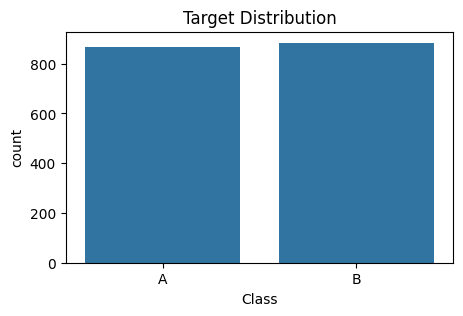

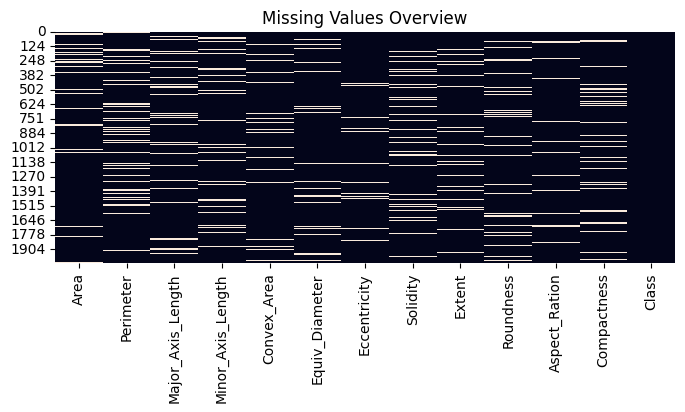

LogReg | Accuracy: 0.8832 | F1-score: 0.8832
HistGradientBoost | Accuracy: 0.8860 | F1-score: 0.8860
RandomForest | Accuracy: 0.8917 | F1-score: 0.8917

Best model selected (by F1-score): RandomForest
Saved: submission_probabilities.csv


In [10]:
# ======================== IMPORTS ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV


# ======================== REPRODUCIBILITY ========================
np.random.seed(42)


# ======================== CONFIG ========================
TRAIN_PATH = "/content/train.csv"
TEST_PATH  = "/content/test.csv"
TARGET = "Class"
ID_COL = "id"


# ======================== LOAD DATA ========================
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

train.columns = train.columns.str.strip()
test.columns  = test.columns.str.strip()

train = train.dropna(subset=[TARGET])

print("Train shape:", train.shape)
print("Test shape :", test.shape)


# ======================== LIGHT EDA ========================
print("\nTarget distribution:")
print(train[TARGET].value_counts())

plt.figure(figsize=(5,3))
sns.countplot(x=train[TARGET])
plt.title("Target Distribution")
plt.show()

plt.figure(figsize=(8,3))
sns.heatmap(train.isnull(), cbar=False)
plt.title("Missing Values Overview")
plt.show()


# ======================== FEATURES / TARGET ========================
X = train.drop(columns=[TARGET], errors="ignore")
y = train[TARGET]

X_test = test.drop(columns=[ID_COL], errors="ignore")
test_ids = test[ID_COL] if ID_COL in test.columns else None


# ======================== TARGET ENCODING ========================
le = LabelEncoder()
y = le.fit_transform(y)


# ======================== CLASS WEIGHTS ========================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y),
    y=y
)
class_weight_dict = dict(zip(np.unique(y), class_weights))


# ======================== FEATURE TYPES ========================
num_cols = X.select_dtypes(include="number").columns
cat_cols = X.select_dtypes(exclude="number").columns


# ======================== PREPROCESSING ========================
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])


# ======================== MODELS ========================
models = {
    "LogReg": LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight="balanced"
    ),

    "HistGradientBoost": HistGradientBoostingClassifier(
        random_state=42
    ),

    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight=class_weight_dict,
        n_jobs=-1
    )
}


# ======================== TRAIN / VALIDATE ========================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scores = {}

for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)

    acc = accuracy_score(y_val, preds)
    f1  = f1_score(y_val, preds, average="weighted")

    scores[name] = f1
    print(f"{name} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")


# ======================== SELECT BEST MODEL ========================
best_name = max(scores, key=scores.get)
best_model = models[best_name]

print(f"\nBest model selected (by F1-score): {best_name}")


# ======================== CALIBRATED FINAL PIPELINE ========================
calibrated_model = CalibratedClassifierCV(
    best_model,
    method="isotonic",
    cv=3
)

final_pipe = Pipeline([
    ("prep", preprocess),
    ("model", calibrated_model)
])

final_pipe.fit(X, y)


# ======================== TEST PREDICTIONS ========================
test_preds = final_pipe.predict(X_test)
test_preds = le.inverse_transform(test_preds)


# ============================================================
#     1) SUBMISSION WITH LABEL PREDICTIONS (C, CL, D)
#     👉 Use this when sample submission has: id, Class
# ============================================================

# label_preds = final_pipe.predict(X_test)
# label_preds = le.inverse_transform(label_preds)

# submission_labels = pd.DataFrame({
#     ID_COL: test_ids,
#     TARGET: label_preds
# })

# submission_labels.to_csv("submission_labels.csv", index=False)
# print("Saved: submission_labels.csv")


# ============================================================
#     2) SUBMISSION WITH PROBABILITIES (Status_C, Status_CL, Status_D)
#     👉 Use this when sample submission has probability columns
# ============================================================

probs = final_pipe.predict_proba(X_test)

# classes learned by LabelEncoder (safe)
classes = list(le.classes_)    # e.g. ['CL', 'C', 'D']

submission_probs = pd.DataFrame({
    ID_COL: test_ids
})

# create probability columns safely
for i, cls in enumerate(classes):
    submission_probs[f"Status_{cls}"] = probs[:, i]

submission_probs.to_csv("submission_probabilities.csv", index=False)
print("Saved: submission_probabilities.csv")





In [ ]:
from google.colab import drive
drive.mount('/content/drive')